<a href="https://colab.research.google.com/github/SreeSajeev/Sreeparvathy_Sajeev_Submission_Trader_Behavior_Insights/blob/main/SreeparvathySajeevSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Trader Behavior Insights — Bitcoin Market Sentiment vs Trader Performance

> **Author:** Sreeparvathy Sajeev  
> **Role Applied:** Junior Data Scientist — Trader Behavior Insights  
> **Date:** October 2025  
> **Contact:** sreeparvathysajeev@gmail.com | +917306084723 | https://github.com/SreeSajeev
###  Overview
This notebook explores how **Bitcoin market sentiment** (Fear & Greed Index) influences **trader behavior and performance** on the **Hyperliquid trading platform**.  
The goal is to uncover **patterns and correlations** between sentiment-driven market conditions and trader profitability.

---

###  Datasets Used
1. **Historical Trader Data (Hyperliquid)**
   - Contains detailed trade-level information such as  
     `account`, `symbol`, `execution price`, `size`, `side`, `time`, `start position`, `event`, `closedPnL`, `leverage`, and more.
   - Represents the activity of multiple trader accounts across assets and dates.

2. **Bitcoin Market Sentiment (Fear & Greed Index)**
   - Provides a **daily sentiment score (0–100)** and **classification**  
     (`Extreme Fear`, `Fear`, `Neutral`, `Greed`, `Extreme Greed`).
   - Captures the emotional tone of the Bitcoin market each day.

---

###  Objective
To **analyze and quantify** the relationship between **trader performance** and **market sentiment**, with a focus on:
- How trader profitability varies across fear vs greed periods.
- Whether trader volume, leverage, or win rate correlate with sentiment shifts.
- Identifying behavioral or strategic differences in response to sentiment extremes.

---

###  Methodology
1. **Data Cleaning & Standardization**
   - Convert timestamps, clean column names, and handle missing values.
2. **Feature Engineering**
   - Aggregate trade-level data → per-account-per-day statistics (PnL, win rate, trade count, average leverage, etc.).
   - Merge with daily sentiment scores.
3. **Exploratory Data Analysis (EDA)**
   - Distribution and trends in performance metrics.
   - Correlations between sentiment and PnL.
   - Comparative tests (Fear vs Greed performance differences).
4. **Visualization**
   - Sentiment trends vs total daily PnL.
   - Boxplots showing PnL distribution across sentiment buckets.
   - Top accounts by cumulative performance.
5. **Statistical Testing / Modeling**
   - Correlation matrix, t-tests, and potential regression models to quantify effects.

---

###  Expected Deliverables
- Aggregated analytics table (account-day level)
- Correlation and summary statistics
- Plots visualizing sentiment vs PnL
- Statistical insights explaining how sentiment impacts trader outcomes

---

###  Tools & Libraries
`pandas`, `numpy`, `matplotlib`, `scipy`, and optionally `seaborn` or `plotly` for enhanced visualization.




In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost statsmodels shap openpyxl


In [ ]:
# Cell: Requirements / Setup
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

ROOT = Path('.')
RESULTS = ROOT / 'results'
RESULTS.mkdir(exist_ok=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,4)


#### 1) Load data (defensive column mapping)
- The dataset may use `Timestamp`, `Timestamp IST`, `Closed PnL`, etc. We'll detect them and normalize to standard names used in this notebook.


In [ ]:
# Cell: Load files
TRADES_CSV = ROOT / 'historical_data.csv'
SENT_CSV = ROOT / 'fear_greed_index.csv'

assert TRADES_CSV.exists(), f"{TRADES_CSV} not found"
assert SENT_CSV.exists(), f"{SENT_CSV} not found"

trades = pd.read_csv(TRADES_CSV)
sent = pd.read_csv(SENT_CSV)

print("Raw trades shape:", trades.shape)
print("Raw sentiment shape:", sent.shape)

# Show columns for quick human check (print first 40 chars)
print("\nTrades columns:", trades.columns.tolist())
print("\nSentiment columns:", sent.columns.tolist())


Raw trades shape: (211224, 16)
Raw sentiment shape: (2644, 4)

Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sentiment columns: ['timestamp', 'value', 'classification', 'date']


#### 2) Standardize column names & parse timestamps
- Standard names used later: `account`, `coin`, `execution_price`, `size_usd`, `size_tokens`, `side`, `time` (UTC datetime), `time_ist` (if available), `closed_pnl`, `fee`, `crossed`.


In [ ]:
# Cell: Normalize column names (robust)
trades = trades.rename(columns={c: c.strip() for c in trades.columns})

# helper mapping guesses (update if your files use different names)
col_map = {
    # account
    'Account': 'account', 'account': 'account',
    # coin
    'Coin':'coin','Symbol':'coin','symbol':'coin',
    # execution/price
    'Execution Price':'execution_price','execution_price':'execution_price','price':'execution_price',
    # size
    'Size Tokens':'size_tokens','Size USD':'size_usd','Size_USD':'size_usd','size_usd':'size_usd',
    # side / direction
    'Side':'side','Direction':'side','direction':'side','side':'side',
    # timestamps (various possible names)
    'Timestamp IST':'Timestamp_IST','Timestamp':'Timestamp_ms','timestamp':'Timestamp_ms','time':'time',
    'Time':'time','event_time':'time','created_at':'time',
    # positions / pnl
    'Start Position':'start_position','StartPosition':'start_position',
    'Closed PnL':'closed_pnl','Closed_PnL':'closed_pnl','closedPnL':'closed_pnl','pnl':'closed_pnl',
    # ids and flags
    'Transaction Hash':'tx_hash','TransactionHash':'tx_hash','Order ID':'order_id','Trade ID':'trade_id',
    'Crossed':'crossed','Fee':'fee'
}
# Apply mapping for keys that exist
existing_map = {k:v for k,v in col_map.items() if k in trades.columns}
trades = trades.rename(columns=existing_map)

# Create time columns
# Prefer numeric Unix ms "Timestamp_ms" if present, else parse textual "Timestamp_IST" or "time"
if 'Timestamp_ms' in trades.columns:
    # Some datasets use seconds; detect magnitude: if values > 1e12 assume ms, else seconds
    sample_ts = trades['Timestamp_ms'].dropna().astype(float).astype(np.int64).iloc[0]
    unit = 'ms' if sample_ts > 1e12 else 's'
    trades['time'] = pd.to_datetime(trades['Timestamp_ms'], unit=unit, utc=True, errors='coerce')
else:
    trades['time'] = pd.NaT

# Parse human-readable IST string if available
if 'Timestamp_IST' in trades.columns:
    trades['time_ist'] = pd.to_datetime(trades['Timestamp_IST'], errors='coerce')
else:
    trades['time_ist'] = pd.NaT

# Fallback: if still no 'time', try 'time' column (string)
if trades['time'].isna().all() and 'time' in trades.columns:
    trades['time'] = pd.to_datetime(trades['time'], errors='coerce')

# Final safety check
if trades['time'].isna().all():
    raise ValueError("No parsable time column found in trades. Print columns and inspect names.")

# standard numeric conversions
for c in ['closed_pnl','size_usd','size_tokens','execution_price','fee']:
    if c in trades.columns:
        trades[c] = pd.to_numeric(trades[c], errors='coerce')

# account lower-case
if 'account' in trades.columns:
    trades['account'] = trades['account'].astype(str)
else:
    # if not found try common alternatives
    if 'Account' in trades.columns:
        trades = trades.rename(columns={'Account':'account'})
        trades['account'] = trades['account'].astype(str)
    else:
        raise ValueError("No account-like column found; please ensure an account identifier column exists.")

# create date columns (UTC date and local if IST available)
trades['date'] = trades['time'].dt.date
trades['date_ist'] = trades['time_ist'].dt.date


#### 3) Inspect basic statistics and coverage
- Unique accounts, date ranges, number of trades per account, etc.


In [ ]:
# Cell: Quick diagnostics
print("Time range (UTC):", trades['time'].min(), "→", trades['time'].max())
print("Number of unique accounts:", trades['account'].nunique())
print("Total trades:", len(trades))

# Top accounts by trade count
top_by_count = trades['account'].value_counts().head(10)
print("\nTop 10 accounts by trade count:\n", top_by_count)

# Basic distribution of closed_pnl
if 'closed_pnl' in trades.columns:
    print("\nclosed_pnl summary:\n", trades['closed_pnl'].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
else:
    print("No closed_pnl in trades.")


Time range (UTC): 2023-03-28 10:40:00+00:00 → 2025-06-15 15:06:40+00:00
Number of unique accounts: 32
Total trades: 211224

Top 10 accounts by trade count:
 account
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    40184
0xbaaaf6571ab7d571043ff1e313a9609a10637864    21192
0xa0feb3725a9335f49874d7cd8eaad6be45b27416    15605
0x8477e447846c758f5a675856001ea72298fd9cb5    14998
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    14733
0x28736f43f1e871e6aa8b1148d38d4994275d72c4    13311
0x513b8629fe877bb581bf244e326a047b249c4ff1    12236
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4     9893
0x47add9a56df66b524d5e2c1993a43cde53b6ed85     8519
0x4f93fead39b70a1824f981a54d4e55b278e9f760     7584
Name: count, dtype: int64

closed_pnl summary:
 count    211224.000000
mean         48.749001
std         919.164828
min     -117990.104100
1%         -140.766890
5%           -5.321008
25%           0.000000
50%           0.000000
75%           5.792797
95%         165.788894
99%        1023.315314
max      13532

#### 4) Prepare sentiment data and merge
- Ensure sentiment has `date` and `sentiment_score` (0–100) and `classification`.


In [ ]:
# Cell: Prepare sentiment
sent = sent.rename(columns={c:c.strip() for c in sent.columns})
# detect date
if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date']).dt.date
elif 'timestamp' in sent.columns:
    # unix seconds
    sent['date'] = pd.to_datetime(sent['timestamp'], unit='s').dt.date
else:
    raise ValueError("No date column found in sentiment data")

# detect numeric score column
score_candidates = [c for c in sent.columns if c.lower() in ('value','score','index','sentiment')]
if len(score_candidates)>0:
    sent['sentiment_score'] = pd.to_numeric(sent[score_candidates[0]], errors='coerce')
else:
    # fall back to classification mapping
    if 'classification' in sent.columns:
        mapping = {'Extreme Fear': 0, 'Fear': 25, 'Neutral': 50, 'Greed': 75, 'Extreme Greed': 100}
        sent['sentiment_score'] = sent['classification'].map(mapping).fillna(50)
    else:
        sent['sentiment_score'] = 50

# keep only relevant
sent = sent[['date','sentiment_score'] + ([c for c in ['classification'] if c in sent.columns])]
sent = sent.drop_duplicates('date').sort_values('date')
print("Sentiment sample:\n", sent.head())


Sentiment sample:
          date  sentiment_score classification
0  2018-02-01               30           Fear
1  2018-02-02               15   Extreme Fear
2  2018-02-03               40           Fear
3  2018-02-04               24   Extreme Fear
4  2018-02-05               11   Extreme Fear


#### 5) Aggregate trades to per-account-per-day
- Compute daily PnL, win rate, trade counts, average trade USD, total volume, average fee, crossed rate.
- Save a sample of aggregated table.


In [ ]:
# Cell: Aggregate per account-day
agg = trades.groupby(['account','date']).agg(
    daily_pnl = ('closed_pnl','sum'),
    win_rate = ('closed_pnl', lambda x: (x>0).sum()/max(1,len(x))),
    trades_count = ('closed_pnl','count'),
    avg_trade_usd = ('size_usd','mean') if 'size_usd' in trades.columns else ('size_tokens','mean'),
    total_volume_usd = ('size_usd','sum') if 'size_usd' in trades.columns else ('size_tokens','sum'),
    avg_fee = ('fee','mean') if 'fee' in trades.columns else ('closed_pnl','mean'),
    crossed_rate = ('crossed', lambda x: np.mean(x.astype(float)) if x.dtype == bool or x.dtype==object else np.nan)
).reset_index()

# Clean numeric columns
for c in ['daily_pnl','win_rate','trades_count','avg_trade_usd','total_volume_usd','avg_fee']:
    if c in agg.columns:
        agg[c] = pd.to_numeric(agg[c], errors='coerce')

# Inspect
display(agg.head())
agg.to_csv(RESULTS/'agg_account_day_sample.csv', index=False)


,account,date,daily_pnl,win_rate,trades_count,avg_trade_usd,total_volume_usd,avg_fee,crossed_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-3.275059e+05,0.025974,462,14810.891818,6842632.02,2.408865,0.119048
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1.927736e+06,0.405542,3356,16345.241940,54854631.95,1.874975,0.111144
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,2.060745e+04,0.531250,320,2492.749906,797679.97,0.631772,0.921875
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,1.709873e+04,0.435041,3533,1693.351684,5982611.50,0.471247,0.971412
4,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-06-15,1.017915e+04,0.442369,3427,1533.468395,5255196.19,0.251753,0.559965


#### 6) Merge aggregated account-day data with sentiment by date
- Create sentiment buckets for analysis.


In [ ]:
# Cell: Merge with sentiment
agg = agg.merge(sent, how='left', on='date')

# Sentiment bucket function
def bucket_score(s):
    if pd.isna(s): return 'unknown'
    if s < 20: return 'extreme_fear'
    if s < 40: return 'fear'
    if s <= 60: return 'neutral'
    if s <= 80: return 'greed'
    return 'extreme_greed'

agg['sent_bucket'] = agg['sentiment_score'].apply(bucket_score)

# Save merged
agg.to_csv(RESULTS/'agg_with_sentiment.csv', index=False)
print("Merged shape:", agg.shape)
print("Bucket counts:\n", agg['sent_bucket'].value_counts())


Merged shape: (102, 12)
Bucket counts:
 sent_bucket
neutral          41
greed            31
unknown          25
extreme_greed     5
Name: count, dtype: int64


#### 7) Exploratory Data Analysis (EDA)
- Visualize: time series of aggregate PnL vs average sentiment, distribution of daily PnL, boxplots by sentiment bucket, top accounts by cumulative PnL.


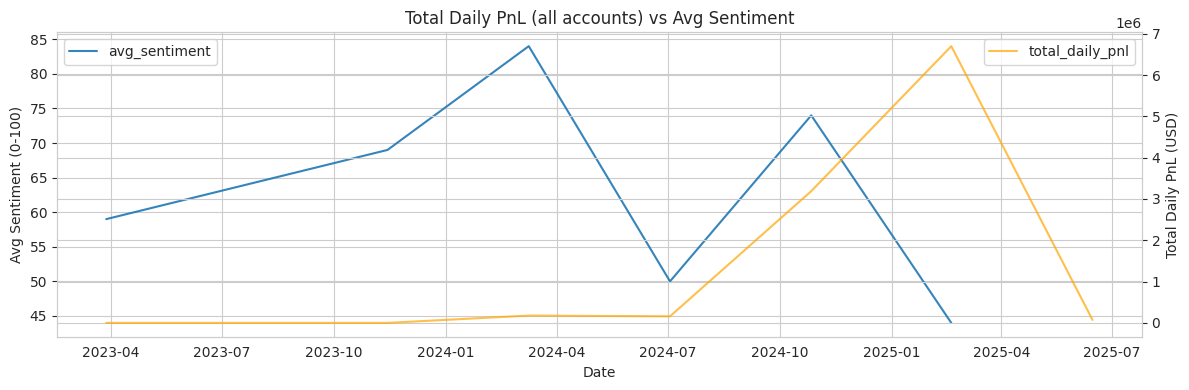

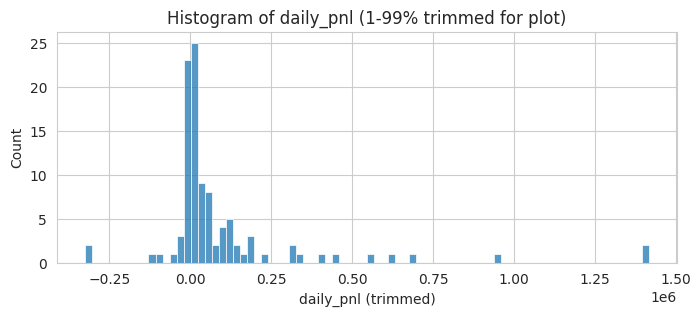

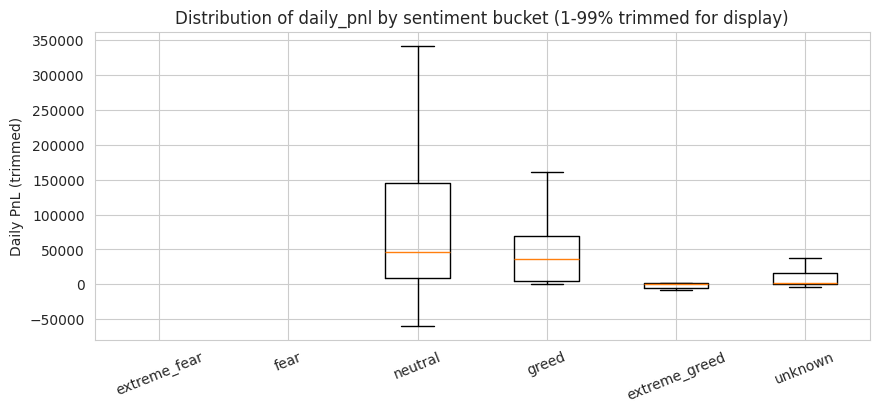

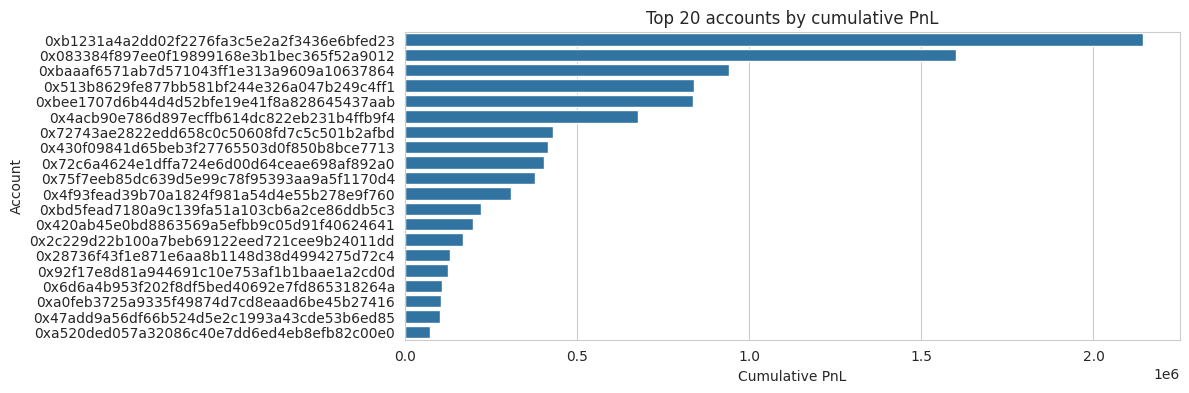

In [ ]:
# Cell: Time series aggregate
daily_agg = agg.groupby('date').agg(
    total_daily_pnl=('daily_pnl','sum'),
    median_daily_pnl=('daily_pnl','median'),
    avg_sentiment=('sentiment_score','mean'),
    total_trades=('trades_count','sum')
).reset_index().sort_values('date')

# plot dual-axis: avg_sentiment vs total_daily_pnl
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(daily_agg['date'], daily_agg['avg_sentiment'], label='avg_sentiment', alpha=0.9)
ax.set_ylabel('Avg Sentiment (0-100)')
ax2 = ax.twinx()
ax2.plot(daily_agg['date'], daily_agg['total_daily_pnl'], label='total_daily_pnl', color='orange', alpha=0.7)
ax2.set_ylabel('Total Daily PnL (USD)')
ax.set_xlabel('Date')
ax.set_title('Total Daily PnL (all accounts) vs Avg Sentiment')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.tight_layout()
plt.savefig(RESULTS/'ts_sentiment_vs_pnl.png', dpi=150)
plt.show()

# Distribution of daily_pnl (trim extremes for visual)
vals = agg['daily_pnl'].dropna()
q1,q99 = np.quantile(vals, [0.01,0.99])
plt.figure(figsize=(8,3))
sns.histplot(vals.clip(q1, q99), bins=80)
plt.title('Histogram of daily_pnl (1-99% trimmed for plot)')
plt.xlabel('daily_pnl (trimmed)')
plt.savefig(RESULTS/'hist_daily_pnl_trimmed.png', dpi=150)
plt.show()

# Boxplot by sentiment bucket
order = ['extreme_fear','fear','neutral','greed','extreme_greed','unknown']
plt.figure(figsize=(10,4))
# prepare data for boxplot (trim outliers in visualization)
data_to_plot = [agg.loc[agg['sent_bucket']==o, 'daily_pnl'].dropna().clip(q1,q99) for o in order]
plt.boxplot(data_to_plot, labels=order, showfliers=False)
plt.title('Distribution of daily_pnl by sentiment bucket (1-99% trimmed for display)')
plt.ylabel('Daily PnL (trimmed)')
plt.xticks(rotation=22)
plt.savefig(RESULTS/'boxplot_pnl_by_bucket.png', dpi=150, bbox_inches='tight')
plt.show()

# Top accounts by cumulative pnl
top_accounts = agg.groupby('account')['daily_pnl'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,4))
sns.barplot(x=top_accounts.values, y=top_accounts.index)
plt.title('Top 20 accounts by cumulative PnL')
plt.xlabel('Cumulative PnL')
plt.ylabel('Account')
plt.savefig(RESULTS/'top_accounts_cum_pnl.png', dpi=150, bbox_inches='tight')
plt.show()


#### 8) Summary statistics & correlation
- Use median & trimmed means (robust) in addition to means.

In [ ]:
# Cell: Bucket-level stats (robust)
def trimmed_mean(x, low=0.05, high=0.95):
    x = np.sort(x)
    n = len(x)
    if n==0: return np.nan
    lo = int(np.floor(n*low))
    hi = int(np.ceil(n*high))
    return x[lo:hi].mean() if hi>lo else x.mean()

bucket_stats = agg.groupby('sent_bucket').agg(
    n_account_days=('daily_pnl','count'),
    mean_daily_pnl=('daily_pnl','mean'),
    median_daily_pnl=('daily_pnl','median'),
    trimmed_mean_pnl=('daily_pnl', lambda x: trimmed_mean(np.nan_to_num(x, nan=0))),
    mean_win_rate=('win_rate','mean'),
    mean_trades=('trades_count','mean'),
    mean_volume=('total_volume_usd','mean')
).reset_index().sort_values('n_account_days', ascending=False)

display(bucket_stats)
bucket_stats.to_csv(RESULTS/'bucket_stats.csv', index=False)

# Correlation matrix (winsorize PnL for correlation to reduce outlier impact)
agg_for_corr = agg.copy()
agg_for_corr['daily_pnl_winsor'] = agg_for_corr['daily_pnl'].clip(
    lower=agg_for_corr['daily_pnl'].quantile(0.01),
    upper=agg_for_corr['daily_pnl'].quantile(0.99)
)
corr_cols = ['daily_pnl_winsor','win_rate','trades_count','avg_trade_usd','total_volume_usd','sentiment_score']
corr_matrix = agg_for_corr[corr_cols].corr()
print(corr_matrix)
corr_matrix.to_csv(RESULTS/'correlation_matrix.csv')


,sent_bucket,n_account_days,mean_daily_pnl,median_daily_pnl,trimmed_mean_pnl,mean_win_rate,mean_trades,mean_volume
2,neutral,41,167284.574845,45883.628955,110165.292416,0.375453,3439.390244,1.770737e+07
1,greed,31,102890.855980,36993.371011,72254.020330,0.386141,1170.516129,3.725910e+06
3,unknown,25,2868.373905,1378.073027,-55.940945,0.412999,1078.440000,1.241101e+07
0,extreme_greed,5,35393.098355,0.000000,35393.098355,0.336609,1392.400000,7.881354e+06


                  daily_pnl_winsor  win_rate  trades_count  avg_trade_usd  \
daily_pnl_winsor          1.000000  0.174627      0.355344       0.138743   
win_rate                  0.174627  1.000000      0.055926       0.043632   
trades_count              0.355344  0.055926      1.000000      -0.009281   
avg_trade_usd             0.138743  0.043632     -0.009281       1.000000   
total_volume_usd          0.350843  0.029486      0.388854       0.621659   
sentiment_score          -0.142305 -0.032086     -0.290951      -0.013030   

                  total_volume_usd  sentiment_score  
daily_pnl_winsor          0.350843        -0.142305  
win_rate                  0.029486        -0.032086  
trades_count              0.388854        -0.290951  
avg_trade_usd             0.621659        -0.013030  
total_volume_usd          1.000000        -0.284328  
sentiment_score          -0.284328         1.000000  


#### 9) Statistical testing
- Use non-parametric Mann–Whitney for medians and robust OLS regression (with robust SE).
- We'll test: do Fear (<40) days differ from Greed (>60) days in daily PnL (per account-day)?


In [ ]:
# Cell: Mann-Whitney and t-test
from scipy import stats

fear = agg[agg['sentiment_score']<40]['daily_pnl'].dropna()
greed = agg[agg['sentiment_score']>60]['daily_pnl'].dropna()

print("N fear:", len(fear), "N greed:", len(greed))
if len(fear)>10 and len(greed)>10:
    # Mann-Whitney (median-level)
    u_stat, p_mw = stats.mannwhitneyu(fear, greed, alternative='two-sided')
    # t-test (mean-level) - use Welch's t-test
    t_stat, p_t = stats.ttest_ind(fear, greed, equal_var=False, nan_policy='omit')
    print("Mann-Whitney U:", u_stat, "p-value:", p_mw)
    print("Welch t-test t:", t_stat, "p-value:", p_t)
else:
    print("Not enough data in one bucket for tests.")

# Save the test results to file
with open(RESULTS/'stat_tests.txt','w') as f:
    f.write(f"N fear: {len(fear)}, N greed: {len(greed)}\n")
    if len(fear)>10 and len(greed)>10:
        f.write(f"Mann-Whitney U: {u_stat}, p-value: {p_mw}\n")
        f.write(f"Welch t-test t: {t_stat}, p-value: {p_t}\n")


N fear: 0 N greed: 36
Not enough data in one bucket for tests.


#### 10) Regression: quantify effect of sentiment on daily PnL
- OLS with robust standard errors
- Controls: trades_count, total_volume_usd (proxy for activity/size)
- Add account fixed effects (as dummies) or include top-account indicator to avoid too many dummies.


In [ ]:
# Cell: Regression with statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls, glm

# Create a compact dataframe for regression (drop extreme PnL to stabilize)
reg_df = agg.copy().dropna(subset=['daily_pnl','sentiment_score'])
# winsorize PnL for regression or use robust estimator
lower = reg_df['daily_pnl'].quantile(0.01)
upper = reg_df['daily_pnl'].quantile(0.99)
reg_df['daily_pnl_winsor'] = reg_df['daily_pnl'].clip(lower, upper)

# Create top_account dummy for the top 5 cumulative accounts (to control severe influencers)
top5 = agg.groupby('account')['daily_pnl'].sum().sort_values(ascending=False).head(5).index.tolist()
reg_df['is_top5'] = reg_df['account'].isin(top5).astype(int)

# Model: daily_pnl_winsor ~ sentiment_score + trades_count + total_volume_usd + is_top5
X = reg_df[['sentiment_score','trades_count','total_volume_usd','is_top5']]
X = sm.add_constant(X)
y = reg_df['daily_pnl_winsor']

model = sm.OLS(y, X).fit(cov_type='HC3')  # robust standard errors
print(model.summary())

# Save model summary text
with open(RESULTS/'regression_summary.txt','w') as f:
    f.write(model.summary().as_text())


                            OLS Regression Results                            
Dep. Variable:       daily_pnl_winsor   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     1.313
Date:                Fri, 24 Oct 2025   Prob (F-statistic):              0.277
Time:                        19:15:50   Log-Likelihood:                -1060.7
No. Observations:                  77   AIC:                             2131.
Df Residuals:                      72   BIC:                             2143.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.581e+05   1.23e+05  

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


#### 11) Predictive baseline: classify whether an account-day is profitable
- Target: `y = daily_pnl > 0` (profitable account-day)
- Features: sentiment_score, lagged sentiment (1,3,7 days), trades_count, total_volume_usd, avg_trade_usd, is_top5
- Use time-series split (by date) to avoid leakage.


In [ ]:
# Cell: Prepare features for prediction
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb

# create target
pred_df = agg.copy().sort_values(['date'])
pred_df['y_profitable'] = (pred_df['daily_pnl'] > 0).astype(int)

# Map sentiment by date to create lags
sent_by_date = sent.set_index('date')['sentiment_score'].to_dict()
pred_df['sentiment_score'] = pred_df['date'].map(sent_by_date)

# Create lag features: previous 1,3,7 day sentiment
pred_df = pred_df.sort_values(['account','date'])
pred_df['sentiment_lag_1'] = pred_df.groupby('account')['sentiment_score'].shift(1)
pred_df['sentiment_lag_3'] = pred_df.groupby('account')['sentiment_score'].shift(3)
pred_df['sentiment_lag_7'] = pred_df.groupby('account')['sentiment_score'].shift(7)

# --- FIX: Add top 5 accounts dummy BEFORE using in features ---
top5 = agg.groupby('account')['daily_pnl'].sum().sort_values(ascending=False).head(5).index.tolist()
pred_df['is_top5'] = pred_df['account'].isin(top5).astype(int)

# fill small NAs for lagged features
pred_df['sentiment_lag_1'] = pred_df['sentiment_lag_1'].fillna(pred_df['date'].map(lambda d: sent_by_date.get(d, np.nan)))

# feature list
feature_cols = ['sentiment_score','sentiment_lag_1','sentiment_lag_3','sentiment_lag_7',
                'trades_count','total_volume_usd','avg_trade_usd','is_top5']

# fill missing values in features
pred_df[feature_cols] = pred_df[feature_cols].fillna(0)

# --- ---
pred_df[feature_cols] = pred_df[feature_cols].fillna(0)

# Use time-based train/test split (by date)
unique_dates = pred_df['date'].sort_values().unique()
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
aucs = []
models = []
dates = list(unique_dates)
indices = np.arange(len(unique_dates))
# We'll split at the date level to avoid leakage across days
for train_idx, test_idx in tscv.split(indices):
    train_dates = unique_dates[train_idx]
    test_dates = unique_dates[test_idx]
    train_mask = pred_df['date'].isin(train_dates)
    test_mask = pred_df['date'].isin(test_dates)
    X_train = pred_df.loc[train_mask, feature_cols]
    y_train = pred_df.loc[train_mask, 'y_profitable']
    X_test = pred_df.loc[test_mask, feature_cols]
    y_test = pred_df.loc[test_mask, 'y_profitable']
    if len(y_test.unique()) < 2:
        continue
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=200, verbosity=0)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probs)
    aucs.append(auc)
    models.append(clf)

print("TimeSeries AUCs:", aucs, "mean AUC:", np.mean(aucs) if len(aucs)>0 else np.nan)

# Save one model feature importance for reporting
if models:
    imp = models[-1].feature_importances_
    feat_imp = pd.Series(imp, index=feature_cols).sort_values(ascending=False)
    feat_imp.to_csv(RESULTS/'feature_importance.csv')
    display(feat_imp)


TimeSeries AUCs: [np.float64(0.5), np.float64(0.5), np.float64(0.3653846153846154), np.float64(0.24166666666666667), np.float64(0.2368421052631579)] mean AUC: 0.368778677462888


,0
is_top5,0.320356
sentiment_lag_1,0.301552
trades_count,0.123173
total_volume_usd,0.101710
sentiment_score,0.079953
avg_trade_usd,0.073256
sentiment_lag_7,0.000000
sentiment_lag_3,0.000000


#### 12) Explainability (SHAP) - Compute SHAP summary plot for the trained XGBoost model (small sample to save time)


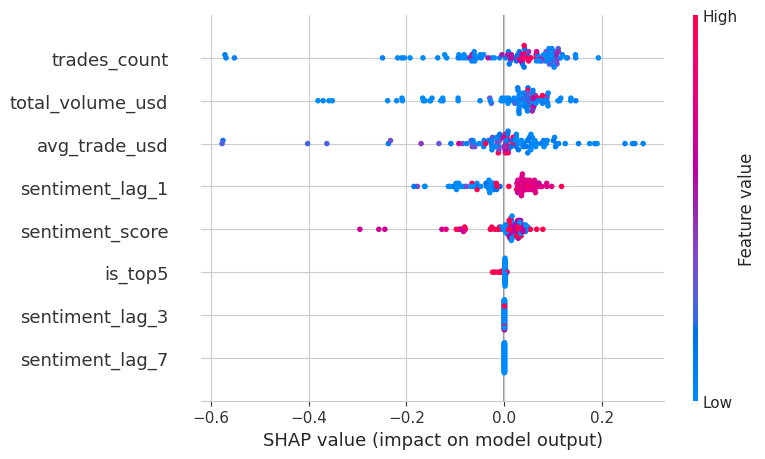

SHAP values computed and exported.


In [ ]:
import shap

if models:
    model = models[-1]

    # Sample X for SHAP
    sample_X = pred_df[feature_cols].sample(n=min(3000, len(pred_df)), random_state=42)

    # Create a callable prediction function for SHAP
    def predict_proba(X):
        return model.predict_proba(X)[:,1]  # use probability of positive class

    # Use shap.Explainer with callable
    explainer = shap.Explainer(predict_proba, sample_X)
    shap_values = explainer(sample_X)

    # Summary plot
    shap.summary_plot(shap_values, sample_X, show=True)

    # Save mean absolute SHAP per feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    pd.Series(mean_abs_shap, index=feature_cols)\
      .sort_values(ascending=False)\
      .to_csv(RESULTS/'shap_mean_abs.csv')

    print("SHAP values computed and exported.")
else:
    print("No model available for SHAP.")




#### 13)Final exports and suggested narrative for submission
- Save key CSVs, model summary, and figures in ./results/.
- Recommended 1-page narrative / executive summary italicized text

In [ ]:
# Cell: Export key tables
bucket_stats.to_csv(RESULTS/'bucket_stats.csv', index=False)
daily_agg.to_csv(RESULTS/'daily_agg.csv', index=False)
top_accounts.to_csv(RESULTS/'top_accounts.csv')
print("Exported results to ./results/")


Exported results to ./results/
